In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import listdir

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
from helpers import dump_pickle, load_pickle, finalize

In [5]:
def files(path):
    return [f for f in listdir(path)]

In [6]:
rt = files('../diploma-news-crawler/.tmp/rt/all-news')

In [7]:
texts = []

for filename in rt:
    with open(f'../diploma-news-crawler/.tmp/rt/all-news/{filename}', 'r') as target:
        src = target.read()

    category, name = filename.split('-')
    
    texts.append(
        {'filename': filename, 'category': category, 'text': src}
    )


## Creating DF

In [9]:
df = pd.DataFrame(texts)
df

,filename,category,text
0,russia-961085.txt,russia,Песков назвал революционной Мюнхенскую речь Пу...
1,russia-961907.txt,russia,Минкультуры приостановило обсуждение проекта п...
2,russia-961046.txt,russia,Суд оштрафовал ректора вуза в Дагестане на 30 ...
3,world-960517.txt,world,Президент США Джо Байден призвал американцев н...
4,russia-960370.txt,russia,Суд в Москве вынес приговор убившему двух мили...
...,...,...,...
925,russia-960369.txt,russia,"Путин заявил, что его слова про «красавицу» и ..."
926,sport-961914.txt,sport,\n Валиева вышла на тренировку после решени...
927,world-960254.txt,world,"Лавров заявил, что западные военные и оружие ч..."
928,ussr-961106.txt,ussr,Военные России и Белоруссии отработали ликвида...


In [10]:
df['final'] = df['text'].apply(finalize)

In [55]:
df.shape[0]

930

In [56]:
df.groupby('category').size()

category
business       35
nopolitics     27
russia        205
science        11
sport         109
ussr          193
world         350
dtype: int64


## Applying

In [11]:
TASS_CATEGORIES = ['obschestvo', 'ekonomika', 'politika', 'sport', 'kultura']
RT_CATEGORIES = ['russia', 'business', 'ussr', 'world', 'sport', 'nopolitics', 'science']

In [12]:
CATEGORIES = {
    0: 'obschestvo',
    1: 'ekonomika',
    2: 'politika',
    3: 'sport',
    4: 'kultura'
}

In [13]:
rfc = load_pickle('tass/classifiers/rfc')
svm = load_pickle('tass/classifiers/svm')
knn = load_pickle('tass/classifiers/knn')
mnbc = load_pickle('tass/classifiers/mnbc')
lr = load_pickle('tass/classifiers/lr')
gbm = load_pickle('tass/classifiers/gbm')

In [14]:
tfidf = load_pickle('tass/tfidf')

In [38]:
def heatmap(actual, predicted):
    d = {act: {} for act in RT_CATEGORIES}

    for i, act in enumerate(actual):
        pred = predicted[i]
        d[act][pred] = d[act].get(pred, 0) + 1

    return [
        [d[act].get(pred, 0) for pred in TASS_CATEGORIES]
        for act in RT_CATEGORIES
    ]



def predict_all(df, classifier):
    def predict(row):
        features = tfidf.transform(pd.Series(finalize(row))).toarray()
        prediction = CATEGORIES.get(classifier.predict(features)[0])
        proba = classifier.predict_proba(features)[0]
        
        return {
            'prediction': prediction,
            'proba': proba,
            'prob': max(proba),
        }
    
    df = df.copy()
    df['all'] = df['final'].apply(predict)
    df['prediction'] = df['all'].apply(lambda x: x['prediction'])
    df['proba'] = df['all'].apply(lambda x: x['proba'])
    df['prob'] = df['all'].apply(lambda x: x['prob'])

    matrix = heatmap(df['category'], df['prediction'])
    plt.figure(figsize=(14, 7))
    sns.heatmap(
        matrix, 
        annot=True,
        xticklabels=TASS_CATEGORIES, 
        yticklabels=RT_CATEGORIES,
        cmap="Purples",
    )
    
    return df


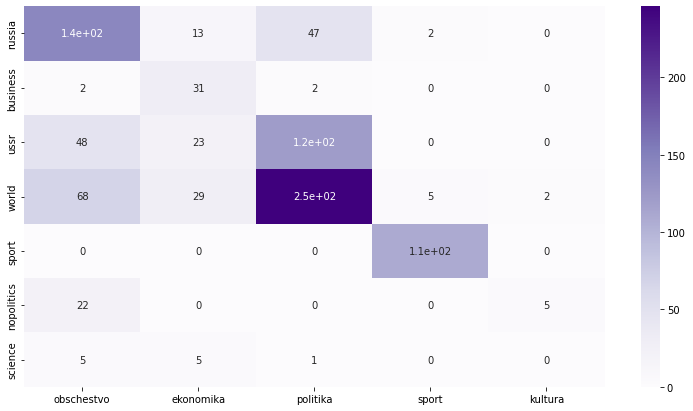

In [16]:
dfRFC = predict_all(df, rfc)

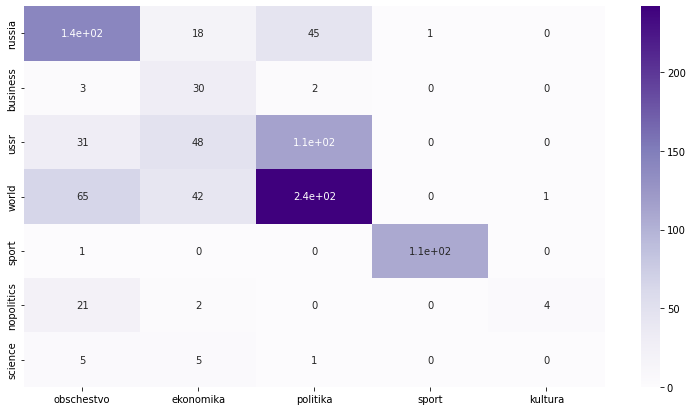

In [17]:
dfSVM = predict_all(df, svm)

In [50]:
dfSVM.loc[(dfSVM['prediction'] == 'sport') & (dfSVM['category'] == 'russia')]

,filename,category,text,final,all,prediction,proba,prob
221,russia-961889.txt,russia,Военные ЦВО развернули в горах баннер в поддер...,военный цво развертывать гора баннер поддержка...,"{'prediction': 'sport', 'proba': [0.2237107323...",sport,"[0.22371073230387398, 0.010825378276333458, 0....",0.748438


In [54]:
dfSVM.iloc[221]['final']

'военный цво развертывать гора баннер поддержка олимпиец « центральный военный округ цво поддержка российский спортсмен участник зимний олимпийский игра пекин развертывать баннер вершина хребет западный саяна цитировать риа новость пресс-служба цво отмечаться ход акция около военный помощь горнолыжный снаряжение преодолевать свыше набор высота завершение восхождение развертывать баннер олимпийский кольцо ранее президент россия владимир путин обращаться мужской национальный сборная лыжный гонка победа эстафета олимпийский игра пекин'

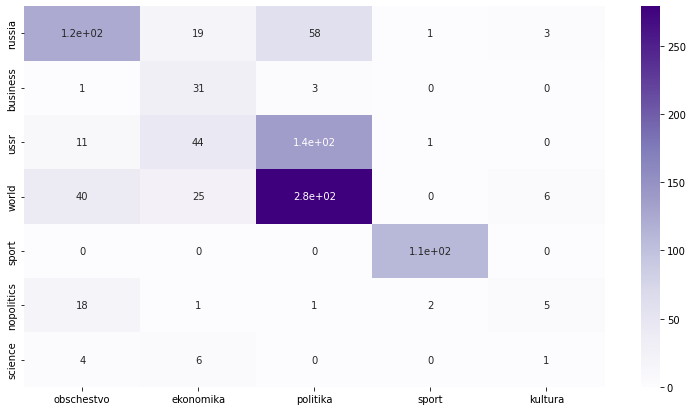

In [18]:
dfKNN = predict_all(df, knn)

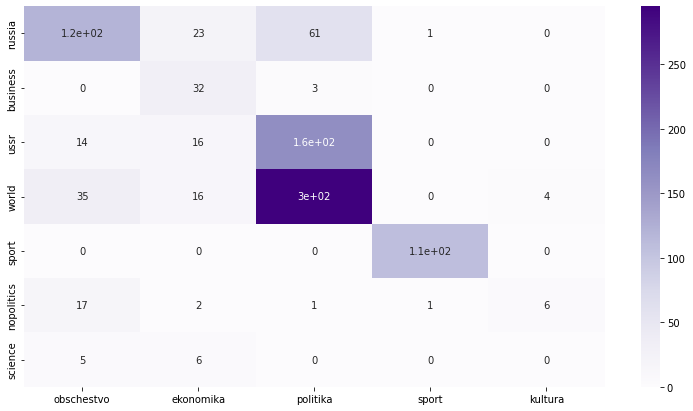

In [22]:
dfMNBC = predict_all(df, mnbc)

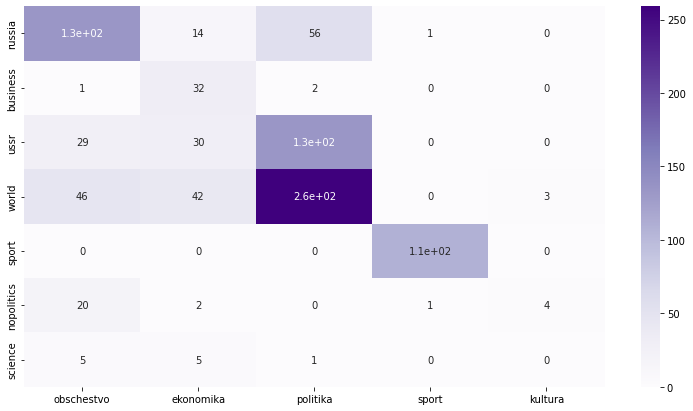

In [23]:
dfLR = predict_all(df, lr)

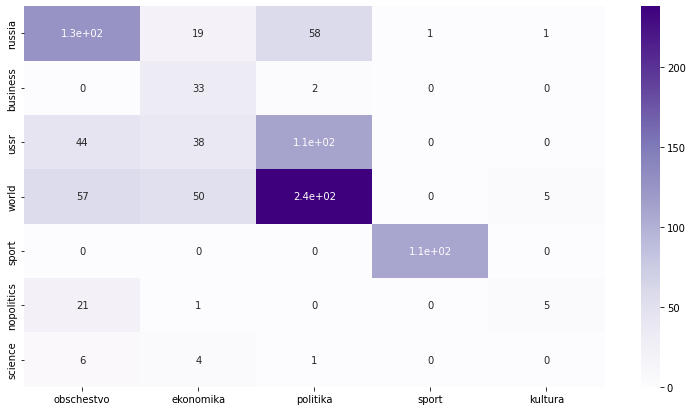

In [24]:
dfGBM = predict_all(df, gbm)